# Load data

In [1]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [3]:
dataset_meta = 'pbmc_1k_v3'
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'
data_raw_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/adata.loom'
raw_data = sc.read_loom(data_raw_loc)

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)
filtered_idx = raw_data.obs['barcode'].isin(np.asarray(bcs_filtered).squeeze())
background_data = raw_data[~filtered_idx]
#background_data.write_loom('data/pbmc_1k_v3_empty.loom')

In [5]:
var_names = pd.read_csv(f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.genes.txt',header=None)
gene_names = pd.DataFrame([ gene.split(".")[0] for gene in var_names[0]])
gene_names

,0
0,ENSG00000278704
1,ENSG00000274847
2,ENSG00000277400
3,ENSG00000278198
4,ENSG00000276256
...,...
36596,ENSG00000286201
36597,ENSG00000286187
36598,ENSG00000286130
36599,ENSG00000288049


In [6]:
gene_info = pd.read_csv('data/biomart_export.csv',header=0)
gene_info

,Gene stable ID,Gene name,Gene description
0,ENSG00000210049,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...
...,...,...,...
69294,ENSG00000162437,RAVER2,"ribonucleoprotein, PTB binding 2 [Source:HGNC ..."
69295,ENSG00000122432,SPATA1,spermatogenesis associated 1 [Source:HGNC Symb...
69296,ENSG00000284882,NaN,novel transcript
69297,ENSG00000289881,NaN,novel transcript


In [7]:
MT_ID = []
nonMT_ID = []
for i in range(len(gene_info)):
    if type(gene_info['Gene name'][i]) is str:
        if gene_info['Gene name'][i][:3] == "MT-":
            MT_ID.append(gene_info['Gene stable ID'][i])
        else:
            nonMT_ID.append(gene_info['Gene stable ID'][i])

# All data

## MT 

In [18]:
MT_idx = gene_names.isin(MT_ID)[0]
data = raw_data.layers[spliced_layer].toarray()
MT_sum = data[:,MT_idx].sum(axis=1)
total_UMI = data.sum(axis=1)

/tmp/ipykernel_1631206/3342215427.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(MT_sum/total_UMI);


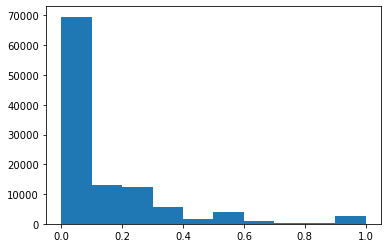

In [21]:
plt.hist(MT_sum/total_UMI);

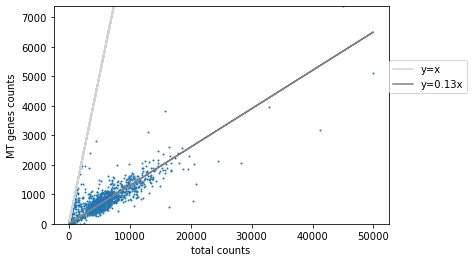

In [19]:
plt.plot(total_UMI, total_UMI,'lightgray',label="y=x");
plt.plot(total_UMI, 0.13*total_UMI,'gray',label="y=0.13x");
plt.scatter(total_UMI, MT_sum,s=1);
plt.xlabel("total counts")
plt.ylabel("MT genes counts")
plt.ylim((0,np.max(MT_sum)))
plt.legend(loc=(1,0.6));

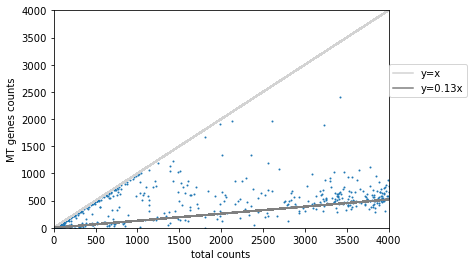

In [20]:
plt.plot(total_UMI, total_UMI,'lightgray',label="y=x");
plt.plot(total_UMI, 0.13*total_UMI,'gray',label="y=0.13x");
plt.scatter(total_UMI, MT_sum,s=1);
plt.xlabel("total counts")
plt.ylabel("MT genes counts")
plt.ylim((0,4000))
plt.xlim((0,4000))
plt.legend(loc=(1,0.6));

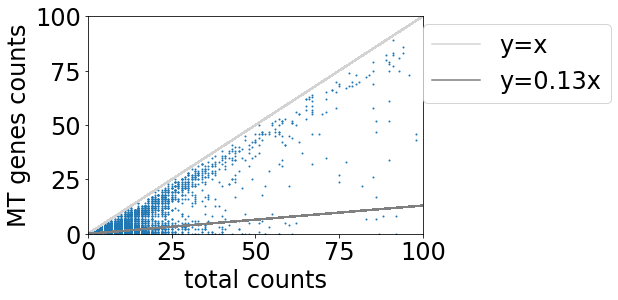

In [350]:
plt.plot(total_UMI, total_UMI,'lightgray',label="y=x");
plt.plot(total_UMI, 0.13*total_UMI,'gray',label="y=0.13x");
plt.scatter(total_UMI, MT_sum,s=1);
plt.xlabel("total counts")
plt.ylabel("MT genes counts")
plt.ylim((0,100))
plt.xlim((0,100))
plt.legend(loc=(1,0.6));

## Mixtures

In [43]:
idx = (raw_data.layers[unspliced_layer].toarray().var(0)>0) & (raw_data.layers[spliced_layer].toarray().var(0)>0)
X = np.zeros((raw_data.n_obs,idx.sum(),2))
X[:,:,0] = raw_data.layers[unspliced_layer].toarray()[:,idx]
X[:,:,1] = raw_data.layers[spliced_layer].toarray()[:,idx]
X.shape

(111231, 14480, 2)

In [44]:
dead_idx = (MT_sum/total_UMI > 0.4)

/tmp/ipykernel_1631206/4059255885.py:1: RuntimeWarning: invalid value encountered in true_divide
  dead_idx = (MT_sum/total_UMI > 0.4)


In [45]:
theta0 = np.zeros((2,raw_data.n_vars,2))
theta0[0,:,0] = raw_data[filtered_idx].layers[unspliced_layer].toarray().mean(0)
theta0[0,:,1] = raw_data[filtered_idx].layers[spliced_layer].toarray().mean(0)
theta0[1,:,0] = raw_data[dead_idx].layers[unspliced_layer].toarray().mean(0)
theta0[1,:,1] = raw_data[dead_idx].layers[spliced_layer].toarray().mean(0)
theta0 /= theta0.sum(axis=(1,2),keepdims=True)

theta0 = theta0[:,idx]
theta0.shape

(2, 14480, 2)

In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from scipy.special import logsumexp, softmax
from scipy.stats import poisson
from tqdm import tqdm 

    
eps = 1e-6


class PoissonMixture:
    """
    Poisson mixture model

    Attributes
    ----------
    n_components : int, number of mixtures, default=1
    theta : ndarray of shape (n_components, p, 2). 
            Means of Poisson distribution for U and S of each gene
    weights : ndarray of shape (n_components,). Weights of each mixture as in GMM.
    """

    def __init__(self, n_components=1, verbose=0):
        self.n_components = n_components
        self.verbose = verbose    
        return
    
    def _get_parameters(self):
        return self.theta.copy(), self.weights.copy()
        
    def _initialize_Q(self, n):
        Q=np.random.uniform(0,1,size=(n, self.n_components))
        Q *= self.weights[None,:]
        Q=Q/Q.sum(axis=(-1),keepdims=True)
        return Q

    def _m_step(self,X,Q):
        # Q: n * n_components
        self.weights = eps+np.sum(Q,axis=0)
        self.weights /= self.weights.sum()   

        self.theta = (Q[:,:,None,None]*X[:,None,:,:]).mean(axis=0)
        if self.rd is not None:
            self.theta /= (Q[:,:,None,None]*self.rd[:,None,None,None]).mean(axis=0)
        else:
            self.theta /= self.weights[:,None,None]
        return

    def _e_step(self,X):
        if self.rd is not None:
            logL = np.sum(poisson.logpmf(k=X[:,None,:,:], mu=self.rd[:,None,None,None]*self.theta[None,:,:,:]), axis=(2,3))
        else:
            logL = np.sum(poisson.logpmf(k=X[:,None,:,:], mu=self.theta[None,:,:,:]), axis=(2,3))
        logL += np.log(self.weights)[None,:]
        logL = np.nan_to_num(logL)
        
        ## Q = softmax(logL, axis=1)
        a = np.amax(logL,axis=(-1),keepdims=True)
        a = np.nan_to_num(a)
        
        relative_L = np.exp(logL-a)
        relative_L = np.nan_to_num(relative_L)
        relative_L_sum = relative_L.sum(axis=(-1),keepdims=True)
        Q = relative_L/relative_L_sum
        lower_bound = np.mean( np.log(relative_L_sum) + a )
        return Q, lower_bound
        
   
    def _fit(self, X, epoch):
        for i in tqdm(range(epoch)):
            Q, lower_bound = self._e_step(X)  
            self._m_step(X, Q)
            print(lower_bound)
        return Q, lower_bound
        
    def fit(self, X, warm_start, Q=None, theta=None, weights=None, read_depth=None, n_init=10, epoch=100, seed=42):
        """  

        Parameters
        ----------
        X : ndarray of shape(n,p,2)
            DESCRIPTION.
        warm_start : TYPE
            DESCRIPTION.
        Q : ndarray of shape(n,n_components)
            Posteriors. The default is None.
        theta : TYPE, optional
            DESCRIPTION. The default is None.
        weights : TYPE, optional
            DESCRIPTION. The default is None.
        n_init : TYPE, optional
            DESCRIPTION. The default is 10.
        epoch : TYPE, optional
            DESCRIPTION. The default is 100.
        seed : TYPE, optional
            DESCRIPTION. The default is 42.

        Returns
        -------
        TYPE
            DESCRIPTION.

        """
        self.warm_start = warm_start
        np.random.seed(seed)
        if read_depth is not None:
            assert np.shape(read_depth) == (len(X),) 
            if read_depth.mean() != 1:
                print("Be aware that read_depth is not normalized")
        self.rd = read_depth 
             
        ### Initialize weights
        if weights is None:
            self.weights = np.ones(self.n_components)/self.n_components
        elif len(weights) == self.n_components:
            self.weights = weights
        else:
            raise ValueError("check weights and n_components")
        
        if warm_start:
            if theta is None:
                assert Q is not None
                self._m_step(X, Q)
            else:
                self.theta = theta.copy()
            return self._fit(X, epoch=epoch)
            
        else:
            max_lower_bound = -np.inf
            n, p, s = X.shape
            for init in range(n_init):
                Q = self._initialize_Q(n)
                self._m_step(X, Q)
                Q, lower_bound = self._fit(X, epoch)
                   
                if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                    max_lower_bound = lower_bound
                    best_params = self._get_parameters()
                    best
                    _Q = Q
    
            self.theta, self.weights = best_params
            return best_Q, max_lower_bound

    def compute_lower_bound(self,X):
        logL = np.sum(poisson.logpmf(k=X[:,None,:,:], mu=self.theta[None,:,:,:]), axis=(2,3))
        logL += np.log(self.weights)[None,:]
        return np.mean(logsumexp(a=logL, axis=1))
    
    def compute_AIC(self, X):
        n, p, s = np.shape(X)
        self.n_parameters = self.theta.size + self.n_components - 1      
        return self.compute_lower_bound(X) - self.n_parameters/n

In [82]:
PM = PoissonMixture(n_components=2)
Q, elbo = PM.fit(X,warm_start=True,theta=theta0,read_depth=None,epoch=3)

Be aware that read_depth is not normalized


  0%|          | 0/3 [00:00<?, ?it/s]/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
 33%|███▎      | 1/3 [04:25<08:51, 265.60s/it]

-inf


 67%|██████▋   | 2/3 [08:43<04:21, 261.23s/it]

-185.98512514391922


100%|██████████| 3/3 [12:58<00:00, 259.56s/it]

-185.95474865953938


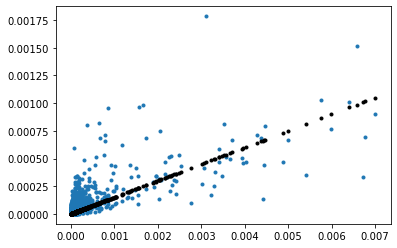

In [88]:
plt.plot(PM.theta[0,:,1],PM.theta[1,:,1],'.')
plt.plot(PM.theta[0,:,1],0.15*PM.theta[0,:,1],'k.')

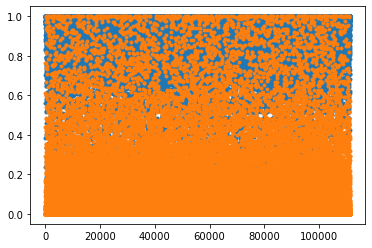

In [89]:
plt.plot(Q,'.')

# Filtered droplets (Cells)

In [300]:
adata = raw_data[filtered_idx]
S = adata.layers[spliced_layer].toarray()

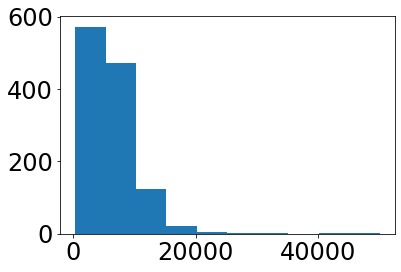

In [111]:
total_UMI = S.sum(axis=1)
plt.hist(total_UMI);

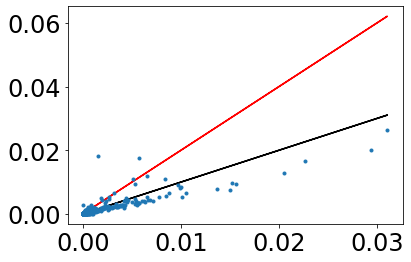

In [119]:
abd = S/total_UMI[:,None]
high_mean = abd[total_UMI>10000].mean(axis=0)
low_mean = abd[total_UMI<=10000].mean(axis=0)
plt.plot(low_mean,low_mean,'k')
plt.plot(low_mean,2*low_mean,'r')
plt.plot(low_mean,high_mean,'.')

In [123]:
outlier_gene_idx = (low_mean > 0.01) | (high_mean > 0.01)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

16


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
21,ENSG00000198899,MT-ATP6,mitochondrially encoded ATP synthase membrane ...
22,ENSG00000198938,MT-CO3,mitochondrially encoded cytochrome c oxidase I...
24,ENSG00000198840,MT-ND3,mitochondrially encoded NADH:ubiquinone oxidor...
27,ENSG00000198886,MT-ND4,mitochondrially encoded NADH:ubiquinone oxidor...
34,ENSG00000198727,MT-CYB,mitochondrially encoded cytochrome b [Source:H...
30084,ENSG00000087086,FTL,ferritin light chain [Source:HGNC Symbol;Acc:H...
30822,ENSG00000112306,RPS12,ribosomal protein S12 [Source:HGNC Symbol;Acc:...


## MT percentages

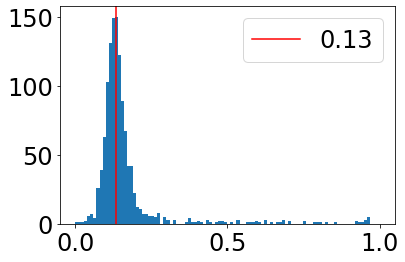

In [311]:
MT_idx = gene_names[0].isin(MT_ID)
MT_perc = S[:,MT_idx].sum(axis=1)/S.sum(axis=1)
plt.hist(MT_perc, bins=np.linspace(0,1,101));
plt.axvline(x=np.median(MT_perc),color='r',label=np.around(np.median(MT_perc),2));
plt.legend()

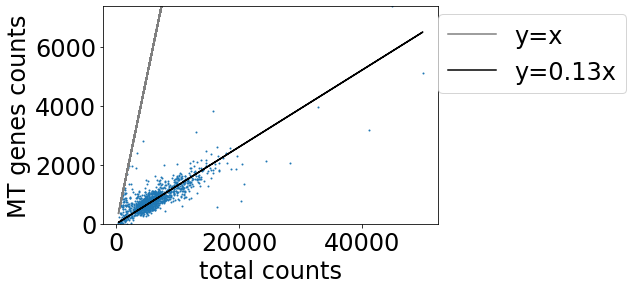

In [334]:
MT_sum = S[:,MT_idx].sum(axis=1)
total_UMI = S.sum(axis=1)

plt.plot(total_UMI, total_UMI,'gray',label="y=x");
plt.plot(total_UMI, 0.13*total_UMI,'black',label="y=0.13x");
plt.scatter(total_UMI, MT_sum,s=1);
plt.xlabel("total counts")
plt.ylabel("MT genes counts")
plt.ylim((0,np.max(MT_sum)))
plt.legend(loc=(1,0.6));

## Covariance

In [6]:
data = adata.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

0.4738271971435195


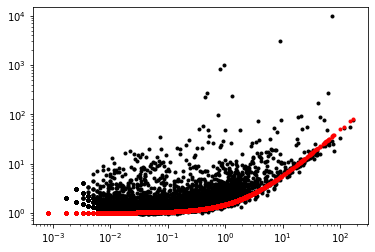

In [7]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

# Background data

In [490]:
data = background_data.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

2.3518886503831204


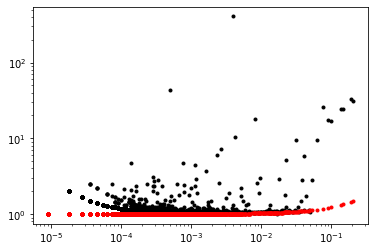

In [9]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

## Check total counts

In [10]:
empty_droplets = raw_data.layers[spliced_layer][~filtered_idx,:].toarray()
total_counts = np.sum(empty_droplets,axis=1)
print(total_counts.max())
print(total_counts.mean(),total_counts.var())

908.0
5.509911 275.34988


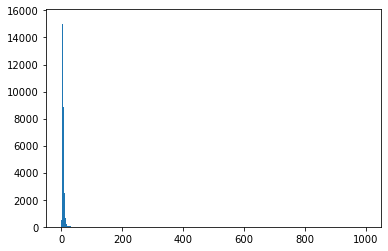

In [10]:
res = plt.hist(total_counts,bins=np.arange(0,1000,1)-0.5);
epmf = res[0]

**The distribution of total counts of "empty" droplets has a long tail**

### Possionion regime

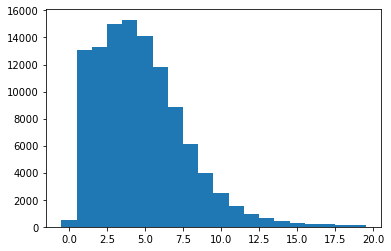

In [11]:
res = plt.hist(total_counts,bins=np.arange(0,21,1)-0.5)
epmf_20 = res[0]

In [12]:
#lam = np.arange(0,20).reshape((1,-1))@epmf.reshape((-1,1))/epmf_20.sum()
#lam = lam[0][0]
lam = total_counts.mean()

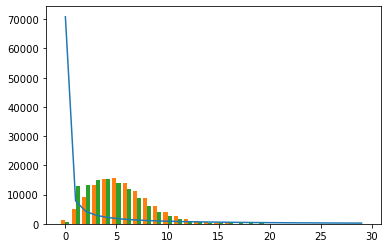

In [13]:
from scipy.stats import poisson, nbinom

sigma2 = total_counts.var() #lam + s*lam**2
p = lam/sigma2
n = lam**2/(sigma2-lam)
prob = nbinom.pmf(np.arange(30), n, p)

c=0.5
x = np.random.poisson(c*np.random.poisson(lam/c,size=110031))

plt.plot(np.arange(30),prob*110031)
plt.hist([x,total_counts],bins=np.arange(0,31,1)-0.5);

In [14]:
print((x>20).sum(),(total_counts>20).sum())

7 967


### Power law regime

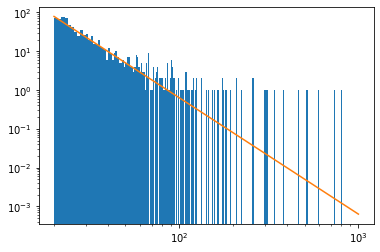

In [15]:
plt.hist(total_counts,bins=np.arange(20,1000,1));
plt.xscale('log')
plt.yscale('log')
plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

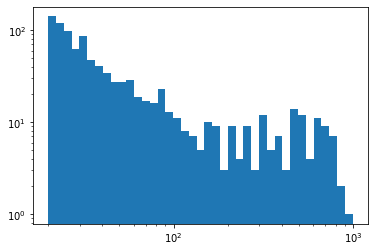

In [16]:
plt.hist(total_counts,bins=np.exp(np.arange(3,7,0.1)));
plt.xscale('log')
plt.yscale('log')
#plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

In [17]:
from scipy.stats import zipf

#pmf_z = zipf.pmf(k=np.arange(0,999,1), a=3)
z = zipf.rvs(a=2.5,size=110000)

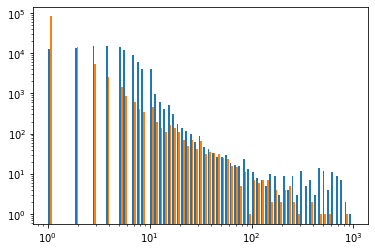

In [18]:
x_=np.exp(np.arange(0,7,0.1))
plt.hist([total_counts,z],bins=x_);
plt.xscale('log')
plt.yscale('log')

## background MT percentages

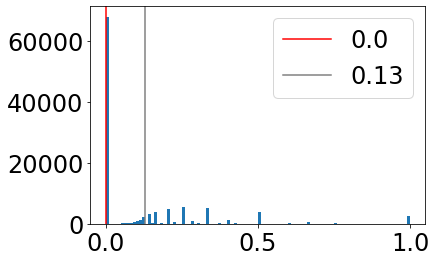

In [356]:
MT_idx = gene_names[0].isin(MT_ID)
empty_S = empty_droplets[(empty_droplets.sum(axis=1)>0)]
MT_perc = empty_S[:,MT_idx].sum(axis=1)/empty_S.sum(axis=1)
plt.hist(MT_perc, bins=np.linspace(0,1,101))
plt.axvline(x=np.median(MT_perc),color='r',label=np.around(np.median(MT_perc),2));
plt.axvline(x=0.13,color='gray',label='0.13');
plt.legend()

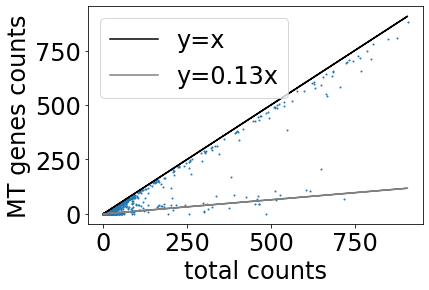

In [336]:
MT_sum = empty_droplets[:,MT_idx].sum(axis=1)
total_UMI = empty_droplets.sum(axis=1)

plt.plot(total_UMI, total_UMI,'k',label="y=x");
plt.plot(total_UMI, 0.13*total_UMI,'gray',label="y=0.13x");
plt.scatter(total_UMI, MT_sum,s=1);
plt.xlabel("total counts")
plt.ylabel("MT genes counts")
plt.legend();

## Clustering

In [8]:
n,p = background_data.shape
X = np.zeros((n,p,2))
X[:,:,0] = background_data.layers[unspliced_layer].toarray()
X[:,:,1] = background_data.layers[spliced_layer].toarray()

In [ ]:
PM = PoissonMixture(n_components=2)
Q, elbo = PM.fit(X,warm_start=False,n_init=3,epoch=5)

 20%|██        | 1/5 [24:44<1:38:59, 1484.93s/it]

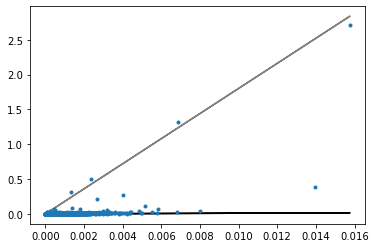

In [37]:
plt.plot(PM.theta[0,:,0],PM.theta[0,:,0],'k');
plt.plot(PM.theta[0,:,0],180*PM.theta[0,:,0],'gray');
plt.plot(PM.theta[0,:,0],PM.theta[1,:,0],'.');

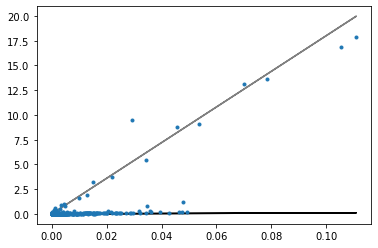

In [32]:
plt.plot(PM.theta[0,:,1],PM.theta[0,:,1],'k');
plt.plot(PM.theta[0,:,1],180*PM.theta[0,:,1],'gray');
plt.plot(PM.theta[0,:,1],PM.theta[1,:,1],'.');

In [19]:
labels = np.argmax(Q,axis=1)

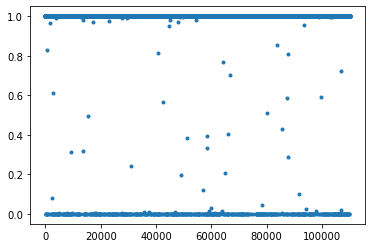

In [27]:
plt.plot(Q[:,0],'.');

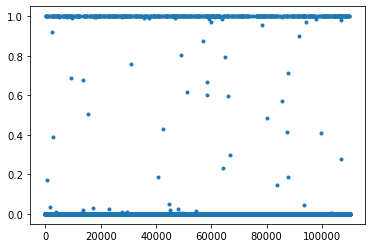

In [28]:
plt.plot(Q[:,1],'.');

In [21]:
(labels == 0).sum()

109473

In [22]:
(labels == 1).sum()

558

(array([1.0947e+05, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  48.6,  97.2, 145.8, 194.4, 243. , 291.6, 340.2, 388.8,
        437.4, 486. ]),
 <BarContainer object of 10 artists>)

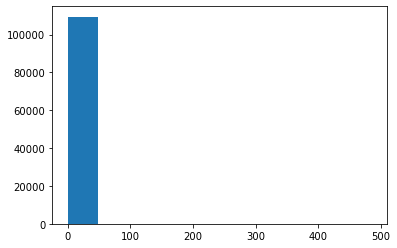

In [33]:
plt.hist(X[(labels == 0),:,1].sum(axis=1));

In [85]:
X[(labels == 0),:,1].sum(axis=1).mean()

4.833420112721859

In [86]:
X[(labels == 1),:,1].sum(axis=1).mean()

138.2293906810036

In [87]:
PM.theta[1,:,1].sum()

138.3689105089371

In [109]:
theta = PM.theta.copy()

In [110]:
theta.shape

(2, 36601, 2)

In [88]:
PM.theta[0,:,1].sum()

4.833437106252251

(array([  0.,   0.,  69., 125.,  58.,  51.,  32.,  20.,  20.,  19.,  11.,
          6.,   7.,   4.,   3.,   6.,   7.,   4.,   4.,   1.,   6.,   3.,
          3.,   0.,   3.,   5.,   2.,   0.,   0.,   3.,   6.,   2.,   4.,
          3.,   1.,   0.,   1.,   1.,   2.,   2.,   3.,   1.,   1.,   0.,
          1.,   2.,   7.,   1.,   1.,   2.,   0.,   6.,   3.,   0.,   3.,
          0.,   1.,   1.,   0.,   1.,   1.,   1.,   2.,   2.,   1.,   2.,
          3.,   0.,   3.,   0.,   1.,   1.,   2.,   1.,   1.,   0.,   3.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.

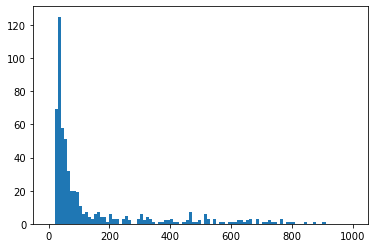

In [91]:
plt.hist(X[(labels == 1),:,1].sum(axis=1),bins=np.linspace(0,1000,101))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = pca.fit_transform(np.append(X[:,:,0],X[:,:,1],axis=1))

In [ ]:
plt.scatter(x[:,0],x[:,1],c=labels)

In [94]:
outlier_gene_idx = (PM.theta[1,:,1] > 2*PM.theta[0,:,1]) & (PM.theta[1,:,1] > 0)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

3672


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
9,ENSG00000198763,MT-ND2,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
20,ENSG00000228253,MT-ATP8,mitochondrially encoded ATP synthase membrane ...
...,...,...,...
69236,ENSG00000116251,RPL22,ribosomal protein L22 [Source:HGNC Symbol;Acc:...
69239,ENSG00000116237,ICMT,isoprenylcysteine carboxyl methyltransferase [...
69270,ENSG00000157216,SSBP3,single stranded DNA binding protein 3 [Source:...
69272,ENSG00000169641,LUZP1,leucine zipper protein 1 [Source:HGNC Symbol;A...


In [98]:
data = background_data.layers[spliced_layer].toarray()[:,~outlier_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

0.18220511160423444


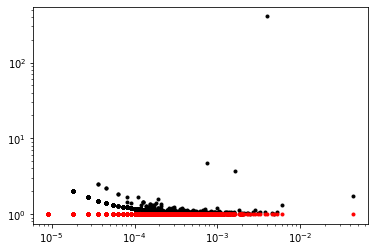

In [99]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

In [96]:
data = background_data.layers[spliced_layer].toarray()[:,outlier_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

23.142851146001572


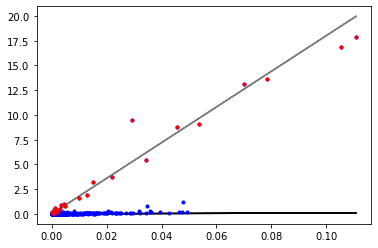

In [58]:
plt.plot(PM.theta[0,:,1],PM.theta[0,:,1],'k');
plt.plot(PM.theta[0,:,1],180*PM.theta[0,:,1],'gray');
plt.plot(PM.theta[0,:,1],PM.theta[1,:,1],'b.');
plt.plot(PM.theta[0,outlier_gene_idx,1],PM.theta[1,outlier_gene_idx,1],'r.');

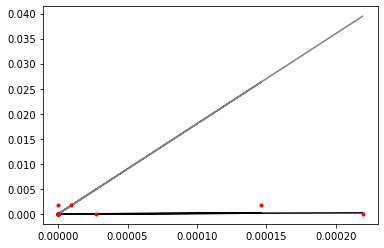

In [60]:
plt.plot(PM.theta[0,outlier_gene_idx,0],PM.theta[0,outlier_gene_idx,0],'k');
plt.plot(PM.theta[0,outlier_gene_idx,0],180*PM.theta[0,outlier_gene_idx,0],'gray');
#plt.plot(PM.theta[0,:,0],PM.theta[1,:,0],'b.');
plt.plot(PM.theta[0,outlier_gene_idx,0],PM.theta[1,outlier_gene_idx,0],'r.');

In [67]:
outlier_gene_idx = (PM.theta[1,:,0] > 100*PM.theta[0,:,0]) & (PM.theta[1,:,0] > 0.01)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

17


,Gene stable ID,Gene name,Gene description
8072,ENSG00000151320,AKAP6,A-kinase anchoring protein 6 [Source:HGNC Symb...
8407,ENSG00000204740,MALRD1,MAM and LDL receptor class A domain containing...
16055,ENSG00000053108,FSTL4,follistatin like 4 [Source:HGNC Symbol;Acc:HGN...
20936,ENSG00000228716,DHFR,dihydrofolate reductase [Source:HGNC Symbol;Ac...
27301,ENSG00000101333,PLCB4,phospholipase C beta 4 [Source:HGNC Symbol;Acc...
29724,ENSG00000108846,ABCC3,ATP binding cassette subfamily C member 3 [Sou...
41394,ENSG00000151090,THRB,thyroid hormone receptor beta [Source:HGNC Sym...
45439,ENSG00000095303,PTGS1,prostaglandin-endoperoxide synthase 1 [Source:...
52383,ENSG00000247134,NaN,novel transcript
52859,ENSG00000227355,NaN,"novel transcript, antisense STOM"


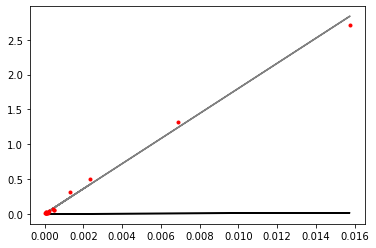

In [84]:
plt.plot(PM.theta[0,outlier_gene_idx,0],PM.theta[0,outlier_gene_idx,0],'k');
plt.plot(PM.theta[0,outlier_gene_idx,0],180*PM.theta[0,outlier_gene_idx,0],'gray');
#plt.plot(PM.theta[0,:,0],PM.theta[1,:,0],'b.');
plt.plot(PM.theta[0,outlier_gene_idx,0],PM.theta[1,outlier_gene_idx,0],'r.');

In [ ]:
outlier_gene_idx

## Abundances are different

In [14]:
filled = empty_droplets[total_counts>20]
empty = empty_droplets[(total_counts<=20)&(total_counts>0)]

In [16]:
filled_mean = (filled/filled.sum(axis=1,keepdims=True)).mean(axis=0)
empty_mean = (empty/empty.sum(axis=1,keepdims=True)).mean(axis=0)

In [17]:
filled.mean()/empty.mean()

19.061483

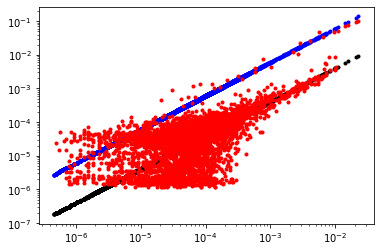

In [22]:
plt.loglog(empty_mean, 0.4*empty_mean,'k.');
plt.loglog(empty_mean, 6*empty_mean,'b.');
plt.loglog(empty_mean, filled_mean,'r.');

(0.0, 0.01)

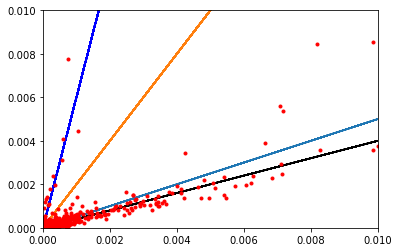

In [23]:
plt.plot(empty_mean, 0.4*empty_mean,'k-');
plt.plot(empty_mean, 0.5*empty_mean,'-');
plt.plot(empty_mean, 2*empty_mean,'-');
plt.plot(empty_mean, 6*empty_mean,'b-');
plt.plot(empty_mean, filled_mean,'r.');
plt.xlim((0,0.01))
plt.ylim((0,0.01))

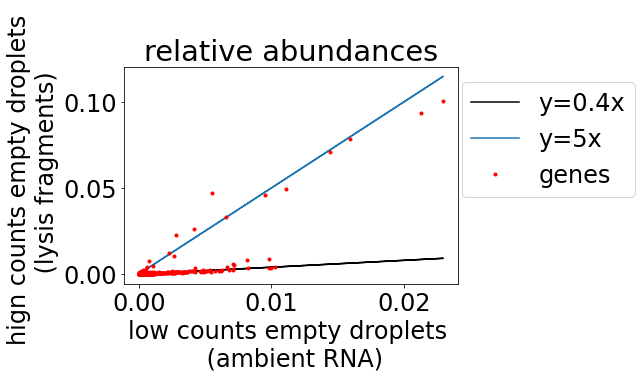

In [43]:
plt.rcParams['font.size'] = '24'

plt.plot(empty_mean, 0.4*empty_mean,'k-',label="y=0.4x");
plt.plot(empty_mean, 5*empty_mean,'-',label="y=5x");
plt.plot(empty_mean, filled_mean,'r.',label="genes");
plt.xlabel("low counts empty droplets \n (ambient RNA)")
plt.ylabel("hign counts empty droplets \n (lysis fragments)")
plt.title("relative abundances")
plt.legend(loc=(1.01,0.4));

In [44]:
cells = adata.layers[spliced_layer].toarray()
cells_mean = (cells/cells.sum(axis=1,keepdims=True)).mean(axis=0)

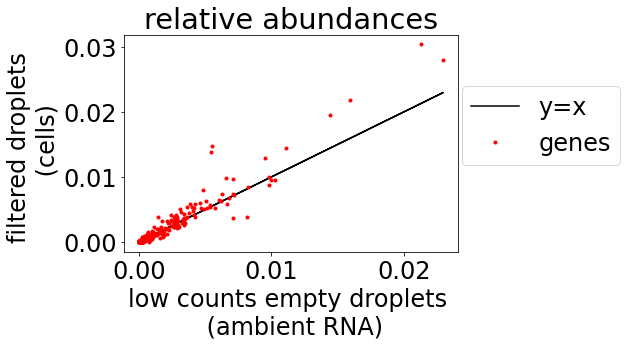

In [47]:
plt.rcParams['font.size'] = '24'

plt.plot(empty_mean, 1*empty_mean,'k-',label="y=x");
#plt.plot(empty_mean, 2*empty_mean,'-');
#plt.plot(empty_mean, 0.5*empty_mean,'-');
plt.plot(empty_mean, cells_mean,'r.',label="genes");
plt.xlabel("low counts empty droplets \n (ambient RNA)")
plt.ylabel("filtered droplets \n (cells)")
plt.title("relative abundances")
plt.legend(loc=(1.01,0.4));

(0.0, 0.01)

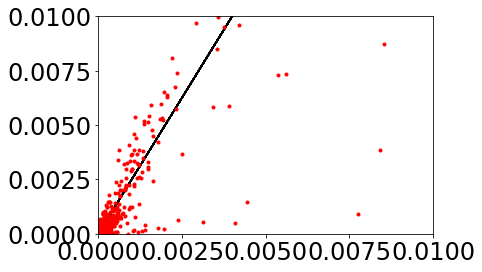

In [46]:
plt.plot(filled_mean, 2.5*filled_mean,'k-');
plt.plot(filled_mean, cells_mean,'r.');
plt.xlim((0,0.01))
plt.ylim((0,0.01))

### Find outlier genes

In [93]:
outlier_gene_idx = (filled_mean > 3*empty_mean) & (filled_mean > 0.001)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

24


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
9,ENSG00000198763,MT-ND2,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
20,ENSG00000228253,MT-ATP8,mitochondrially encoded ATP synthase membrane ...
21,ENSG00000198899,MT-ATP6,mitochondrially encoded ATP synthase membrane ...
22,ENSG00000198938,MT-CO3,mitochondrially encoded cytochrome c oxidase I...
24,ENSG00000198840,MT-ND3,mitochondrially encoded NADH:ubiquinone oxidor...
26,ENSG00000212907,MT-ND4L,mitochondrially encoded NADH:ubiquinone oxidor...
27,ENSG00000198886,MT-ND4,mitochondrially encoded NADH:ubiquinone oxidor...


In [94]:
outlier_gene_idx = (filled_mean > 3*empty_mean) & (filled_mean > 0.0001)
print(outlier_gene_idx.sum())
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes = outlier_genes[0].tolist()
outlier_genes_ = [ gene.split(".")[0] for gene in outlier_genes]
gene_info[gene_info["Gene stable ID"].isin(outlier_genes_)]

55


,Gene stable ID,Gene name,Gene description
5,ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...
9,ENSG00000198763,MT-ND2,mitochondrially encoded NADH:ubiquinone oxidor...
15,ENSG00000198804,MT-CO1,mitochondrially encoded cytochrome c oxidase I...
18,ENSG00000198712,MT-CO2,mitochondrially encoded cytochrome c oxidase I...
20,ENSG00000228253,MT-ATP8,mitochondrially encoded ATP synthase membrane ...
21,ENSG00000198899,MT-ATP6,mitochondrially encoded ATP synthase membrane ...
22,ENSG00000198938,MT-CO3,mitochondrially encoded cytochrome c oxidase I...
24,ENSG00000198840,MT-ND3,mitochondrially encoded NADH:ubiquinone oxidor...
26,ENSG00000212907,MT-ND4L,mitochondrially encoded NADH:ubiquinone oxidor...
27,ENSG00000198886,MT-ND4,mitochondrially encoded NADH:ubiquinone oxidor...


**plot MT genes distribution**

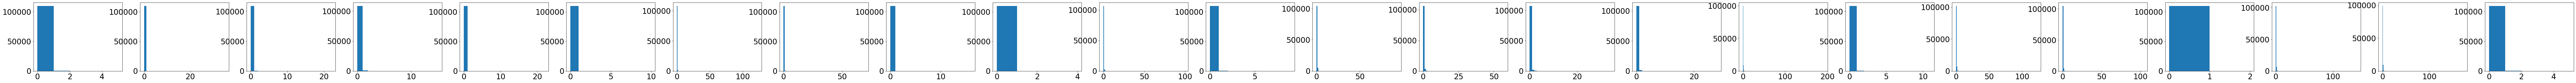

In [51]:
x = empty_droplets[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))    

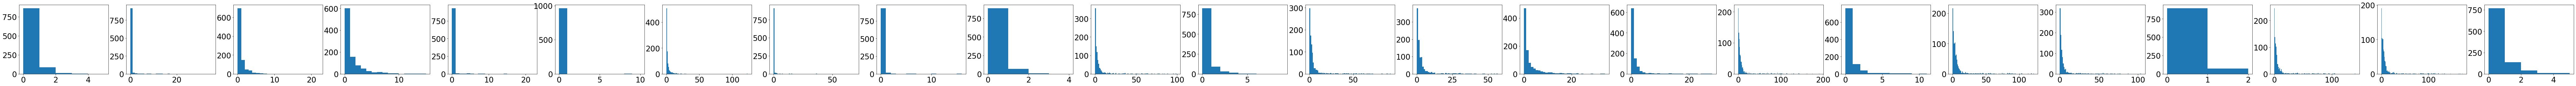

In [52]:
x = filled[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))    

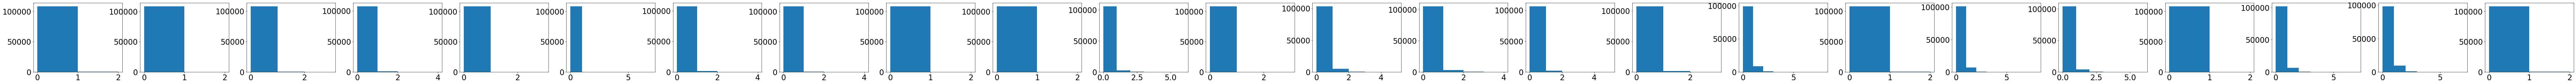

In [53]:
x = empty[:,outlier_gene_idx]
fig, ax = plt.subplots(1,x.shape[1],figsize=(6*x.shape[1],4))
for i in range(x.shape[1]):
    ax[i].hist(x[:,i],bins=np.arange(x[:,i].max()+1))  

In [128]:
gene_names_ = pd.DataFrame([ gene.split(".")[0] for gene in gene_names[0]])
MT_gene_idx = gene_names_[0].isin(MT_ID)

In [130]:
MT_sum = empty_droplets[:,MT_gene_idx].sum(axis=1)
total_UMI = empty_droplets.sum(axis=1)

In [137]:
MT_sum.shape

(110031,)

In [136]:
np.sum(MT_sum == 0)

68456

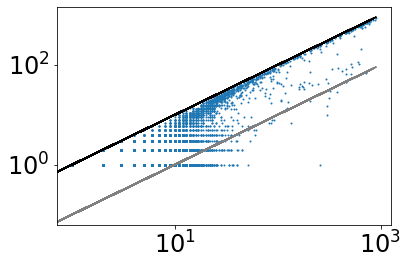

In [147]:
plt.plot(total_UMI, total_UMI,'k');
plt.plot(total_UMI, 0.1*total_UMI,'gray');
plt.scatter(total_UMI, MT_sum,s=1);
plt.xscale('log')
plt.yscale('log')

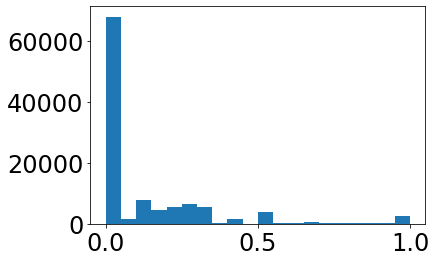

In [145]:
plt.hist(MT_sum[total_UMI>0]/total_UMI[total_UMI>0],bins=np.linspace(0,1,21));

In [85]:
#normal_gene_idx = (filled_mean < 0.5*empty_mean) & (empty_mean > 0)
#print(normal_gene_idx.sum())

data = empty_droplets[:,normal_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

2.2756820756971092


In [101]:
normal_gene_idx = (filled_mean < 0.45*empty_mean) & (empty_mean > 0)
print(normal_gene_idx.sum())

data = empty_droplets[:,normal_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

9225
0.4437724743470413


In [102]:
## only ambient RNA

data = empty
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

0.1470789917932343


### Simulations

In [193]:
pool = empty_droplets.sum(axis=0,dtype=int).reshape((1,-1))

In [240]:
T = pool.sum()
T/n

5.509910843307795

In [282]:
mean = 5.509911 / T
var = 275.34988 / T**2
sd = np.sqrt(np.log(var/mean**2+1))
sd

1.5197160015599602

In [283]:
n,p = empty_droplets.shape
rd = np.random.lognormal(mean=np.log(mean)-(sd**2)/2,sigma=sd,size=n).reshape((-1,1))
print(rd.mean()*T,rd.var()*T**2)

5.432487834013585 265.12534378457684


In [284]:
np.broadcast(pool, rd).shape

(110031, 36601)

In [285]:
samples = np.random.binomial(pool,rd)

In [286]:
samples.shape

(110031, 36601)

In [287]:
total_counts = np.sum(samples,axis=1)
print(total_counts.max())
print(total_counts.mean(),total_counts.var())

1327
5.440966636675119 273.11178030544596


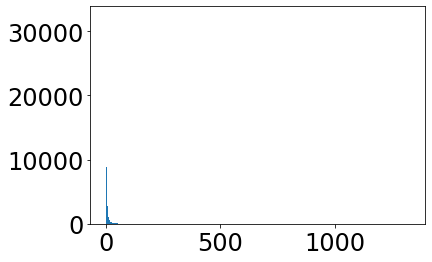

In [289]:
res = plt.hist(total_counts,bins=np.arange(0,1328,1)-0.5);

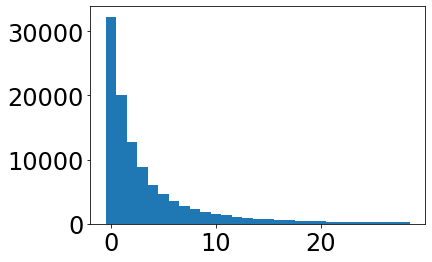

In [290]:
res = plt.hist(total_counts,bins=np.arange(0,30,1)-0.5);

In [292]:
filled = samples[total_counts>20]
empty = samples[(total_counts<=20)&(total_counts>0)]

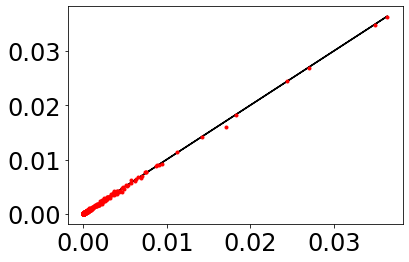

In [294]:
filled_mean = (filled/filled.sum(axis=1,keepdims=True)).mean(axis=0)
empty_mean = (empty/empty.sum(axis=1,keepdims=True)).mean(axis=0)

plt.plot(empty_mean, empty_mean,'k-');
plt.plot(empty_mean, filled_mean,'r.');

# MT distributions

In [475]:
MT_idx = gene_names[0].isin(MT_ID)

In [476]:
X = raw_data.X.toarray()
MT_X = X[:,MT_idx]
MT_total = MT_X.sum(1)
MT_perc = MT_X.sum(1)/X.sum(1)

/tmp/ipykernel_3385401/30439739.py:4: RuntimeWarning: invalid value encountered in true_divide
  MT_perc = MT_X.sum(1)/X.sum(1)


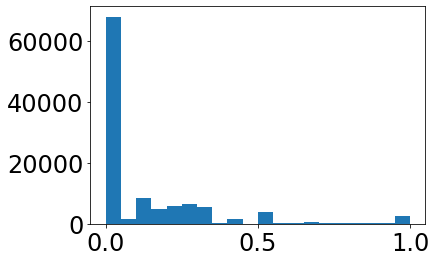

In [477]:
plt.hist(MT_perc,bins=np.linspace(0,1,21));

In [478]:
(MT_perc>0.5).shape
MT_total.shape

(111231,)

In [480]:
high_MT = MT_total[(MT_perc>0.5)]

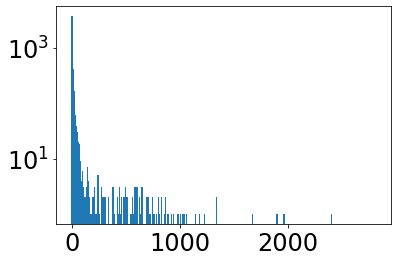

In [484]:
plt.hist(high_MT,bins=np.arange(0,1+high_MT.max(),10)-0.5);
plt.yscale('log')

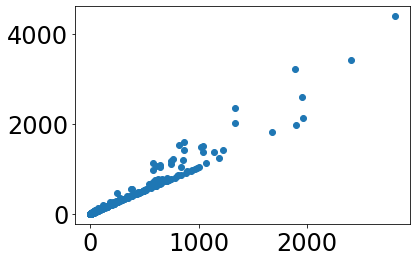

In [483]:
plt.scatter(high_MT,X.sum(1)[(MT_perc>0.5)])

(array([33., 25., 22., 14.,  6.,  9.,  4.,  3.,  8.,  9.,  4.,  6.,  1.,
         2.,  5.,  3.,  6.,  2.,  2.,  7.,  1.,  3.,  5.,  4.,  5.,  9.,
         6.,  0.,  4.,  6.,  4.,  5., 10.,  4., 10.,  5.,  7.,  9.,  9.,
        14.,  8., 12., 14., 13.]),
 array([ 49.5,  59.5,  69.5,  79.5,  89.5,  99.5, 109.5, 119.5, 129.5,
        139.5, 149.5, 159.5, 169.5, 179.5, 189.5, 199.5, 209.5, 219.5,
        229.5, 239.5, 249.5, 259.5, 269.5, 279.5, 289.5, 299.5, 309.5,
        319.5, 329.5, 339.5, 349.5, 359.5, 369.5, 379.5, 389.5, 399.5,
        409.5, 419.5, 429.5, 439.5, 449.5, 459.5, 469.5, 479.5, 489.5]),
 <BarContainer object of 44 artists>)

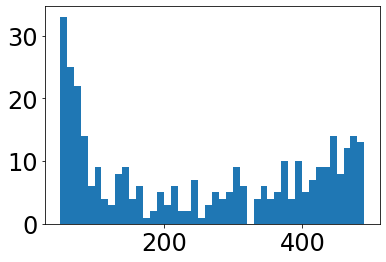

In [435]:
plt.hist(MT_total,bins=np.arange(50,500,10)-0.5)

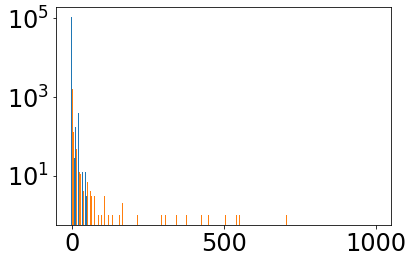

In [411]:
c = 20 #MT_total.var()/MT_total.mean()-1
lam = MT_total.mean()/c
x = np.random.poisson(c*np.random.poisson(lam,size=len(MT_X)))
plt.hist([x,MT_total],bins=np.arange(0,1000)-0.5);
plt.yscale('log')

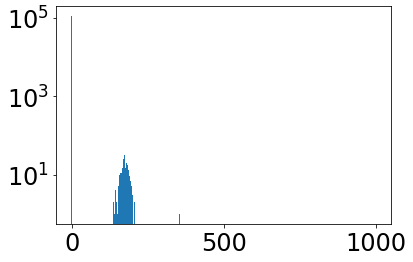

In [396]:
plt.hist(x,bins=np.arange(0,1000)-0.5);
plt.yscale('log')

In [ ]:
Check mito var